# Setup and load data

## Install dependencies and setup

In [1]:
!pip3 install tensorflow-macos tensorflow-metal opencv-python matplotlib pandas

In [2]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import AUC

### Check whether gpu available or not

In [3]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("✅ Using GPU:", gpus)
else:
    print("❌ No GPU found, using CPU")

✅ Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load Labels

In [4]:
# Load CSV
train_df = pd.read_csv("CheXpert-v1.0-small/train.csv")
valid_df = pd.read_csv("CheXpert-v1.0-small/valid.csv")

LABELS = ["Pneumothorax", "Pneumonia", "Edema", "Pleural Effusion", "Consolidation", "Cardiomegaly", "Atelectasis"]

# making dataset binary
train_df[LABELS] = train_df[LABELS].fillna(0).replace(-1, 0)
valid_df[LABELS] = valid_df[LABELS].fillna(0).replace(-1, 0)

# Data Augmentation

In [5]:
rotation_layer = layers.RandomRotation(
    factor=0.05,  # ~±5% of a full turn (~±18 degrees)
    fill_mode="constant"
)

def augment_image(image, label):
    # Random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random contrast adjustment
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Random flip (horizontal only)
    image = tf.image.random_flip_left_right(image)

    # Rotation using keras layer (works on macOS)
    image = rotation_layer(image, training=True)

    # Ensure values stay in [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

2025-09-08 19:10:37.327996: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-09-08 19:10:37.328027: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-08 19:10:37.328031: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-08 19:10:37.328061: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-08 19:10:37.328070: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Dataset for tensorflow

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

def parse_image(filename, label):
    img=tf.io.read_file(filename)
    # decoding jpg to tensor in 3 channels
    img=tf.image.decode_jpeg(img,channels=3)
    img=tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    # normalizing [0,255] to [0,1]
    img=tf.cast(img, tf.float32)/255.0
    return img, label

def df_to_dataset(df, base_dir="X-Ray-Detection-Model", training=False):
    filepaths = df["Path"].values
    # only takes images with the labels defined above
    labels = df[LABELS].values.astype("float32")
    # makes a dataset that pairs each label with their image
    ds=tf.data.Dataset.from_tensor_slices((filepaths, labels))
    # apply parse image in parallel processing to make it faster
    ds=ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    # shuffle the images and make it into batches
    ds=ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds=df_to_dataset(train_df, training=True)
valid_ds=df_to_dataset(valid_df, training=False)

# Building the model

In [7]:
# ready-made brain --> resnet50 already knows detection of edges and shapes and textures so we resue that knowledge with our dataset
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# freeze at start so it doesnt forget basic knowledsge
base_model.trainable = False

model = models.Sequential([
    # squashing all the detected features into vectors
    base_model, layers.GlobalAveragePooling2D(),
    # every iteration it turns some neurons off so that every neuron learns instead of relying on sm neurons
    layers.Dropout(0.5),
    # for every disease giving 0 and 1
    # using sigmoid instead of softmax for multilabeling
    layers.Dense(len(LABELS), activation="sigmoid")
])

# Calculate class weights
# increases the cost of getting something wrong wrt how rare they are so the model doesnt get a easy way out
class_totals = train_df[LABELS].sum().values
total_samples = len(train_df)
class_weights = total_samples / (len(LABELS) * class_totals)
class_weight_dict = {i: class_weights[i] for i in range(len(LABELS))}


# adam tell model how to update itself, loss --> tells the model how wrong it is, metrics --> keeps track of how well the model is doing
model.compile(
    optimizer="adam",
    loss="binary_crossentropy", 
    metrics=[AUC(multi_label=True)]
    )

# Adding callback

In [8]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True
)

# Train

In [9]:
# model.fit --> training begins
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=5,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict)

Epoch 1/5


2025-09-08 19:10:39.311247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


6982/6982 ━━━━━━━━━━━━━━━━━━━━ 2292s 328ms/step - auc: 0.5482 - loss: 0.4380 - val_auc: 0.6730 - val_loss: 0.4969
Epoch 2/5
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 2225s 319ms/step - auc: 0.5642 - loss: 0.4339 - val_auc: 0.6801 - val_loss: 0.4947
Epoch 3/5
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 2209s 316ms/step - auc: 0.5689 - loss: 0.4327 - val_auc: 0.6737 - val_loss: 0.4959
Epoch 4/5
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 2262s 324ms/step - auc: 0.5714 - loss: 0.4319 - val_auc: 0.6854 - val_loss: 0.5180
Epoch 5/5
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 2130s 305ms/step - auc: 0.5747 - loss: 0.4315 - val_auc: 0.6996 - val_loss: 0.4876


## Unfreeze some layers

In [10]:
base_model.trainable=True

# finetuning
for layer in base_model.layers[:-50]:
    layer.trainable = False

## Recompiling with smaller learning rate

In [11]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[AUC(multi_label=True)]
)

## Train

In [12]:
history_fine = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=50,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict
)

Epoch 5/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3573s 510ms/step - auc_1: 0.6007 - loss: 0.4565 - val_auc_1: 0.7476 - val_loss: 0.5493
Epoch 6/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3494s 500ms/step - auc_1: 0.6383 - loss: 0.4113 - val_auc_1: 0.7612 - val_loss: 0.5438
Epoch 7/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3607s 516ms/step - auc_1: 0.6521 - loss: 0.4070 - val_auc_1: 0.7634 - val_loss: 0.4968
Epoch 8/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3538s 507ms/step - auc_1: 0.6588 - loss: 0.4047 - val_auc_1: 0.7865 - val_loss: 0.5057
Epoch 9/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3567s 511ms/step - auc_1: 0.6660 - loss: 0.4024 - val_auc_1: 0.7224 - val_loss: 0.4393
Epoch 10/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3540s 507ms/step - auc_1: 0.6703 - loss: 0.4010 - val_auc_1: 0.7678 - val_loss: 0.4714
Epoch 11/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3456s 495ms/step - auc_1: 0.6749 - loss: 0.3990 - val_auc_1: 0.7727 - val_loss: 0.4478
Epoch 12/50
6982/6982 ━━━━━━━━━━━━━━━━━━━━ 3460s 495ms/step - auc_1: 0.6800 - loss: 0.3975 - va

# Save the model

In [13]:
model.save("best_model.keras")

# Plotting the model stats

KeyError: 'AUC'

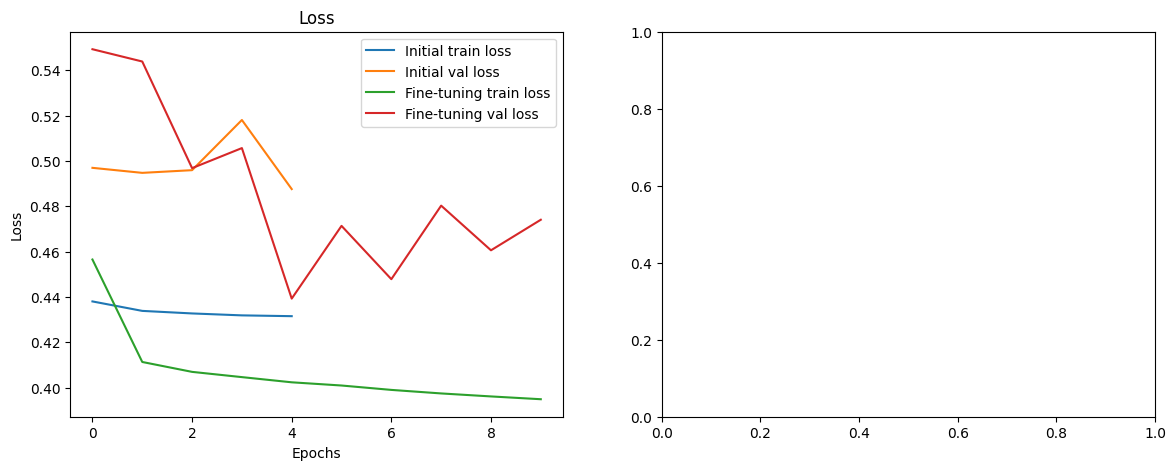

In [16]:
def plot_history(histories, titles):
    plt.figure(figsize=(14,5))
    
    # Plot Loss
    plt.subplot(1,2,1)
    for h, t in zip(histories, titles):
        plt.plot(h.history['loss'], label=f'{t} train loss')
        plt.plot(h.history['val_loss'], label=f'{t} val loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    for h, t in zip(histories, titles):
        plt.plot(h.history['AUC'], label=f'{t} train AUC')
        plt.plot(h.history['val_auc'], label=f'{t} val auc')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Call the function to plot
plot_history([history, history_fine], ['Initial', 'Fine-tuning'])